In [40]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from mongoengine import *
from urllib.parse import urlparse, parse_qsl
connect('mongoengine_documents')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from monary import Monary
mon = Monary()

from scoping.models import *

from mongo_classes import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [17]:
corpus_1990 = list(scopus_doc.objects.filter(PY=1990).values_list('TI'))
len(corpus_1990)

1658

In [11]:
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus_1990)

In [12]:
X.get_feature_names() 

AttributeError: get_feature_names not found

In [37]:
corpus_1995 = list(scopus_doc.objects.filter(PY=1995).values_list('TI'))
X_1995 = vectorizer.fit_transform(corpus_1995)

X = []
for y in [1990,1995,2000,2005,2010,2015]:
    corpus = list(scopus_doc.objects.filter(PY=y,TI__exists=True).values_list('TI'))
    X_y = vectorizer.fit_transform(corpus)
    X.append(X_y)


In [43]:
import nltk
from nltk.stem import SnowballStemmer
import string

stoplist = set(nltk.corpus.stopwords.words("english"))
stoplist.add('elsevier')
stoplist.add('rights')
stoplist.add('reserved')
stoplist.add('john')
stoplist.add('wiley')
stoplist.add('sons')
stoplist.add('copyright')

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    return tokens

class snowball_stemmer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in tokenize(doc)]

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   tokenizer=snowball_stemmer(),
                                   stop_words=stoplist)

tfidf = tfidf_vectorizer.fit_transform(corpus_1995)

In [51]:
dir(tfidf)
tfidf.shape
print(len(corpus_1995))
print(tfidf.shape)

2877
(2877, 1997)


In [60]:
X = []
for y in [1990,1995,2000,2005,2010,2015]:
    print(y)
    corpus = list(scopus_doc.objects.filter(PY=y,AB__exists=True).values_list('AB'))
    X_y = tfidf_vectorizer.fit_transform(corpus)
    X.append(X_y)

1990
1995
2000
2005
2010
2015


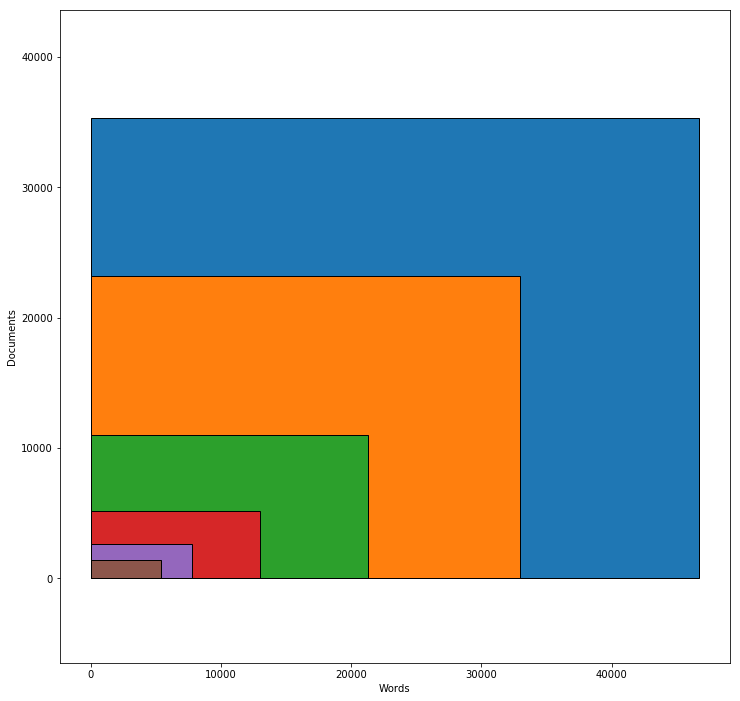

In [65]:
ind = np.arange(1)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

def vvrect(X,colour):
    plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],fill=colour,edgecolor='black')
    

vvrect(X[5], '#fbb4ae')
vvrect(X[4], '#b3cde3')
vvrect(X[3], '#ccebc5')
vvrect(X[2], '#decbe4')
vvrect(X[1], '#fed9a6')
vvrect(X[0], '#ffffcc')

plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
plt.savefig('../plots/volume_variety.png',bbox_inches='tight')

plt.show()

In [56]:
print(X[1].shape)

(2877, 1997)
